## Meta -omic correlations to IBD severity

11/03/2020<br>
Author: Robert Mills<br>
Environment: Qiime2-2019.7<br>
<br>
<i>This notebook contains code for reproducing several figures related to meta -omic associations to IBD from the manuscript, <b> "Meta–omics Reveals Microbiome Driven Proteolysis as a Contributing Factor to Severity of Ulcerative Colitis Disease Activity" </b>by Mills et al. <br><br>
Data sheets used here will be made available on Massive.ucsd.edu

In [1]:
#Import dependencies
import math
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import sys
import scipy
from scipy.stats import linregress
from matplotlib_venn import venn2

In [2]:
#Makes figures with white background
sns.set_style("whitegrid")
#Allows visualization within the ipython notebook format
%matplotlib inline

In [3]:
#Optional for disabling warnings
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [ ]:
#Option for re-enabling warnings
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("default")

#### User defined functions

In [4]:
def LinearRegressions(df,metadata,variable):
    """
    This function will perform linear regressions on all features in a dataframe. Each row is a feature and each column is a sample. The function appends appends new columns for the stats associated with the linear regression.
    A mask is in place to detect missing values, and remove them from the regression. The fraction of samples missing the feature is listed as an additional column.


    
    Parameters
    ----------
    df : pd.DataFrame
    metadata : pd.DataFrame
    variable: String

    Returns
    -------
    Dataframe with stats on linear regressions
    """
    
    samples = list(df.columns)
    meta2 = metadata[metadata.index.isin(samples)]

    #Remove non-numeric samples
    meta3 =	meta2[pd.to_numeric(meta2[variable], errors='coerce').notnull()]
    samples2 = list(meta3.index)
    df2 = df[samples2]

    df2.loc['%s'%(variable)] = meta3[variable].astype('float')

    #Order patients by the variable & add linregress stats
    Order = list(meta3[variable].sort_values().index)
    linregstats =['slope','intercept','rvalue','pvalue','stderr']
    for i in linregstats:
        Order.append(i)

    #Reindex to sort the data columns
    df2 = df2.reindex(columns = Order)

    #Remove the features that have no values (or are a missing value)
    df2 = df2.dropna(axis=0,how='all')
    df2 = df2.loc[df2.index.dropna()]

    #Apply linear regressions to the variable
    slope = []
    intercept = []
    rvalue = []
    pvalue = []
    stderr = []
    sparsity = []

    for i in df2.index:
        a = df2.loc[i]
        b = df2.loc[variable]
        mask = ~np.isnan(df2.loc[i]) & ~np.isnan(df2.loc[variable])
        linres = linregress(a[mask],b[mask])
        #linres = linregress(a[samples],b[samples])
        slope.append(linres.slope)
        intercept.append(linres.intercept)
        rvalue.append(linres.rvalue)
        pvalue.append(linres.pvalue)
        stderr.append(linres.stderr)
        sparsity.append((np.isnan(df2[samples2].loc[i])).astype(int).sum()/len(a[samples2]))
    df2['slope'] = slope
    df2['intercept'] = intercept
    df2['rvalue'] = rvalue
    df2['pvalue'] = pvalue
    df2['stderr'] = stderr
    df2['sparsity_prcnt'] = sparsity

    global df_out
    df_out = df2  
    return 'Linear regressions performed on %s. New dataframe stored as "df_out"'%(variable)

In [158]:
def PlotByCategory_MultiSampleGroups2(df,lists,Taxa_col,category,metadata,display_number,save_descrip,human="True",col_order=False):
    """
    This function allows you to average the abundance of a category by the levels within that category
    and plot stacked barplots of the relative abundance of the x most abundant groups within 
    each level. Can handle multiple groups of samples input into lists
    
    Parameters
    ----------
    df : pd.DataFrame
    lists: list
    Taxa_col : String
    Sparcity: np.float
    variable : Name of variable you're comparing ratios of
    display_number: np.integer
    human: String
    save_descrip : String
    col_order : list

    Returns
    -------
    pdf visualization
    global of Others and top_list for input into other functions
    """
    global Others
    global top_list
    
    num_lists = len(lists)
    all_samples = []
    for i in lists:
        for j in i:
            all_samples.append(j)

    df_all = df[all_samples].groupby(df['%s' % Taxa_col]).agg(['sum'])
    
    #Find the sum per variable
    df_all['sum'] = df_all.sum(axis=1)
        
    #Find the most abundantly entry within the variable, group others
    top_list = list(df_all.sort_values('sum', ascending=False)[0:display_number].index)
    Others = set(df_all.index) - set(top_list)
    top_list.append('Others')

    #A dictionary of dataframes will be needed to store all summed dataframes:
    #df_dict = {}

    #Initialize the figure
    figlength = num_lists*1.75
    fig, axes = plt.subplots(nrows=num_lists,ncols=1,figsize=(1.25,figlength))
    
    for num, i in enumerate(lists, start=1):       
        #Sum your dataframe by a category of interest 
        dfcategories = df[i].groupby(df['%s' % Taxa_col]).agg(['sum'])
        #Restructure the columns which become multilevel with the sum function                  
        dfcategories.columns = dfcategories.columns.droplevel(1)

        if human != "True":
            dfcategories.drop('Homo sapiens (Human)', inplace=True)   
        
        #Save the postive and negative correlations per genera or eggNOG category
        counts = dfcategories
        
        #Find averages according to the levels in a category of interest
        
        #subset metadata to only list with patients of interest
        metadata.index = metadata.index.astype('str')
        meta2 = metadata.loc[i]
        #Identify the levels within the metadata category
        levels_list = list(meta2[category].drop_duplicates().sort_values())
        #Add new column for patients regarding the level of the category of interest.
        counts.loc['%s' % category] = metadata['%s' % category]

        #Create a new column averaging by the levels within the category
        col_list = []
        
        ##NOTE - THIS STEP MAY BE REORDERING LIST SHOULD CHECK
        for j in levels_list:
            a = counts[i].T
            patients_in = []
            patients_in = list(a[a[category] == j].index.astype('str'))
            b = counts[patients_in].drop(category)
            b = b.astype('float')
            counts['%s' % j] = b[patients_in].mean(axis=1)
            col_list.append('%s' % (j))
        

        counts.loc['Others'] = counts.loc[Others].sum()
        plot_df = counts[col_list]
        plot_df = plot_df.loc[top_list]

        #Convert to ratio for display
        for i in col_list:
            plot_df[i] = plot_df[i]/plot_df[i].sum()
        
        plot_df = plot_df[col_list]
        
        #Remove index name
        del plot_df.index.name
        
        #Transpose
        plot_df = plot_df.transpose()
        #Get the dates in the correct order
        if col_order != False:
            plot_df = plot_df.reindex(col_order)
        #Get variable into an order which depends on the abundance of each variable for easier interpretation
        #plot_df = plot_df[plot_df.sum().sort_values(ascending = False).index]
        #df_dict['Group_list%s' % (num)] = plot_df
        
        axenum = num-1
        plot1 = plot_df.plot(kind='bar', ax=axes[axenum], width = 0.8, stacked=True, colors=['black','red','white'], title='')
        #plot1.get_xaxis().set_ticklabels([])
        plot1.get_legend().remove()
    fig.autofmt_xdate(rotation = 90, ha = 'center')
    plot1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.tight_layout()
    fig.savefig('Barplot_of_%s_by_%s_%s.pdf' %(Taxa_col,category,save_descrip),bbox_inches="tight")
    

In [5]:
def TaxaRatioCompareSigLevelGroups(df_dict,sig_level,Taxa_col,variable,Sparsity,display_number,save_descrip,human="True",relative="True"):
    """
    This function combines several lines of code to speed up comparative analyses between two data sets.
    Input the data frames you want to compare and the name of the taxonomic level under Taxa.
    
    Parameters
    ----------
    df_dict : pd.dict
    Taxa_col : String
    sig_level : np.float
    Sparcity: np.float
    variable : Name of variable you're comparing ratios of
    display_number: np.integer
    human: String
    relative: String
    save_descrip : String

    Returns
    -------
    Plot of the composition of significant proteins.
    """
    num_df = len(df_dict)
    
    #Combine all of the proteins in the dictionary and find most common categories
    df_concat = pd.concat(df_dict)

    #Remove spurious correlations with high sparsity
    df_sig = df_concat[df_concat['sparsity_prcnt'] < Sparsity]

    #Subset out the significant positive and negative correlations
    Cal_neg = df_sig[df_sig['rvalue'] < -sig_level]
    Cal_pos = df_sig[df_sig['rvalue'] > sig_level]    

    Cal_neg['%s_Pos' % variable] = 0
    Cal_pos['%s_Pos' % variable] = 1
    Cal_neg['%s_Neg' % variable] = 1
    Cal_pos['%s_Neg' % variable] = 0
    
    df_sig = pd.concat([Cal_neg, Cal_pos])
    
    #Sum by category

    #Use this for summing by taxonomy
    dfcategories = df_sig[['%s_Neg' % variable,'%s_Pos' % variable]].groupby(df_sig['%s' % Taxa_col]).agg(['sum'])
    dfcategories.columns = dfcategories.columns.droplevel(1)

    if human != "True":
        dfcategories.drop('Homo', inplace=True)

    #Save the postive and negative correlations per genera or eggNOG category
    counts = dfcategories

    #Find the sum per variable
    counts['sum'] = counts.sum(axis=1)

    #Find the most abundantly correlated entry within the variable, group others
    top_list = list(counts.sort_values('sum', ascending=False)[0:display_number].index)
    Others = set(counts.index) - set(top_list)
    counts.loc['Others'] = counts.loc[Others].sum()
    top_list.append('Others')

    figwidth = num_df*2
    fig, axes = plt.subplots(nrows=1,ncols=num_df,figsize=(figwidth,3))
    
    for num, i in enumerate(df_dict, start=1):      
        #Remove spurious correlations with high sparsity
        df_sig = df_dict[i][df_dict[i]['sparsity_prcnt'] < Sparsity]

        #Subset out the significant positive and negative correlations
        Cal_neg = df_sig[df_sig['rvalue'] < -sig_level]
        Cal_pos = df_sig[df_sig['rvalue'] > sig_level]

        #Subset out the significant positive and negative correlations MG
        #Cal_neg2 = df2_sig[df2_sig['rvalue'] < 0]
        #Cal_pos2 = df2_sig[df2_sig['rvalue'] > 0]


        #pDB Use this code if you want to simply look at quantity of significant proteins
        Cal_neg['%s_Pos' % variable] = 0
        Cal_pos['%s_Pos' % variable] = 1
        Cal_neg['%s_Neg' % variable] = 1
        Cal_pos['%s_Neg' % variable] = 0

        #MG Use this code if you want to simply look at quantity of significant proteins
        #Cal_neg2['%s_Pos2' % variable] = 0
        #Cal_pos2['%s_Pos2' % variable] = 1
        #Cal_neg2['%s_Neg2' % variable] = 1
        #Cal_pos2['%s_Neg2' % variable] = 0

        df_sig = pd.concat([Cal_neg, Cal_pos])

        #df_sig2 = pd.concat([Cal_neg2, Cal_pos2])

        #Sum by category

        #Use this for summing by taxonomy
        dfcategories = df_sig[['%s_Neg' % variable,'%s_Pos' % variable]].groupby(df_sig['%s' % Taxa_col]).agg(['sum'])
        dfcategories.columns = dfcategories.columns.droplevel(1)

        #Use this for summing by taxonomy
        #dfcategories2 = df_sig2[['%s_Neg2' % variable,'%s_Pos2' % variable]].groupby(df_sig2['%s' % Taxa_col]).agg(['sum'])
        #dfcategories2.columns = dfcategories2.columns.droplevel(1)

        if human != "True":
            dfcategories.drop('Homo', inplace=True)


        #Save the postive and negative correlations per genera or eggNOG category
        counts = dfcategories

        plot_df = counts.loc[top_list]

        #Convert to ratio for display - switch comment activity for relative versus total correlations
        plot_vars = ['%s_Neg' % variable,'%s_Pos' % variable]

        if relative != "True":
            pass
        else:
            for j in plot_vars:
                plot_df[j] = plot_df[j]/plot_df[j].sum()

        plot_df = plot_df[plot_vars]

        #Transpose the plot to make it fit the code structure I'm following for the stacked bar chart

        #Remove index name
        del plot_df.index.name
        #Transpose
        plot_df = plot_df.transpose()
        #Get the dates in the correct order
        plot_df = plot_df.reindex(plot_vars)
        #Get variable into an order which depends on the abundance of each variable for easier interpretation
        plot_df = plot_df[top_list]
        axenum = num-1   
        plot1 = plot_df.plot(kind='bar', ax=axes[axenum], width = 0.8, stacked=True, colormap='tab20c', title='%s' %i)
        #plot1.get_xaxis().set_ticklabels([])
        plot1.get_legend().remove()
    plot1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.tight_layout()
    fig.savefig('Barplot_of_%s_correlations_at_%s_sparsity_%s.pdf' %(variable,Sparsity,save_descrip),bbox_inches="tight")


    
    return 'New plot saved.'

In [ ]:
def TaxaLogRatioCompareSigLevelGroupsCombine(df_dict,sig_level,Taxa_col,variable,Sparsity,
                                             MinCount,human="True",compareall="False"):
    """
    This function provides a dictionary of comparative analyses between 
    the groupings of significant features. Input a dictionary of different datasets to compare
    under the same settings for significance level, sparsity and filtering human features.
    Compare all switches between comparing only features above or below the absolute value
    of the significance threshold or comparing all within a significance threshold to
    the values below that threshold. Input the column of the category you want to compare in
    "Taxa_col"
    
    Parameters
    ----------
    df_dict : pd.dict
    Taxa_col : String
    sig_level : np.float
    Sparcity: np.float
    variable : Name of variable you're comparing ratios of
    display_number: np.integer
    human: String
    relative: String
    save_descrip : String
    MinCount : np.integer
    compareall: String

    Returns
    -------
    Plot of the composition of significant proteins.
    """
    global ratio_dict
    num_df = len(df_dict)

    #figwidth = num_df*5
    #fig, axes = plt.subplots(nrows=1,ncols=num_df,figsize=(figwidth,6))
    
    ratio_dict = {}
    for num, i in enumerate(df_dict, start=1):      
        #Remove spurious correlations with high sparsity
        df_sig = df_dict[i][df_dict[i]['sparsity_prcnt'] < Sparsity]
        
        if compareall=="False":
            #Subset out the significant positive and negative correlations
            Cal_neg = df_sig[df_sig['rvalue'] < -abs(sig_level)]
            Cal_pos = df_sig[df_sig['rvalue'] > abs(sig_level)]
        else:
            if sig_level > 0:
                Cal_neg = df_sig[df_sig['rvalue'] < sig_level]
                Cal_pos = df_sig[df_sig['rvalue'] >= sig_level]
            else:
                Cal_neg = df_sig[df_sig['rvalue'] <= sig_level]
                Cal_pos = df_sig[df_sig['rvalue'] > sig_level]                  


        #Subset out the significant positive and negative correlations MG
        #Cal_neg2 = df2_sig[df2_sig['rvalue'] < 0]
        #Cal_pos2 = df2_sig[df2_sig['rvalue'] > 0]


        #pDB Use this code if you want to simply look at quantity of significant proteins
        Cal_neg['%s_Pos' % variable] = 0
        Cal_pos['%s_Pos' % variable] = 1
        Cal_neg['%s_Neg' % variable] = 1
        Cal_pos['%s_Neg' % variable] = 0

        df_sig = pd.concat([Cal_neg, Cal_pos])

        #Sum by category

        #Use this for summing by taxonomy
        dfcategories = df_sig[['%s_Neg' % variable,'%s_Pos' % variable]].groupby(df_sig['%s' % Taxa_col]).agg(['sum'])
        dfcategories.columns = dfcategories.columns.droplevel(1)

        dfcategories['sum'] = dfcategories['%s_Neg' % variable] + dfcategories['%s_Pos' % variable]


        if human != "True":
            dfcategories.drop('Homo sapiens (Human)', inplace=True)


        #Save the postive and negative correlations per genera or eggNOG category
        counts = dfcategories

        #Add a Pseudocount of 1 so that the categories without anything are still shown
        dfcategories = counts.replace(0,1)
        
        #Find the ratios necessary for calculating the ratio of ratios
        dfcategories['%s_Percent_Neg' % variable] = \
        dfcategories['%s_Neg' % variable]/dfcategories['%s_Neg' % variable].sum()
        dfcategories['%s_Percent_Pos' % variable] = \
        dfcategories['%s_Pos' % variable]/dfcategories['%s_Pos' % variable].sum()

        dfcategories['%s_Ratio of Percentages (Pos/Neg)' % variable] = dfcategories['%s_Percent_Pos' % variable]/dfcategories['%s_Percent_Neg' % variable]
        
        dfcategories['Log(Pos/Neg)'] = np.log10(dfcategories['%s_Ratio of Percentages (Pos/Neg)' % variable])

        dfcategories['Category'] = ("%s" % i)
        dfcategories['#Proteins'] = dfcategories['sum'].astype('str')
        #dfcategories = dfcategories.loc[top_list]
        #dfcategories.index = dfcategories['Category and #Proteins']
        df = dfcategories[dfcategories['sum'] > MinCount]
        df = df.sort_values('Log(Pos/Neg)')
        df.reset_index(inplace=True)
        
        ratio_dict["%s"%i] = df


    
    return 'All ratio dataframes combined into "ratio_dict".'

In [76]:
def PlotByCategory_MultiSampleGroups(df,lists,Taxa_col,category,metadata,display_number,save_descrip,human="True",size=9):
    """
    This function allows you to average the abundance of a category by the levels within that category
    and plot stacked barplots of the relative abundance of the x most abundant groups within 
    each level. Can handle multiple groups of samples input into lists
    
    Parameters
    ----------
    df : pd.DataFrame
    lists: list
    Taxa_col : String
    variable : Name of variable you're comparing ratios of
    display_number: np.integer
    human: String
    save_descrip : String
    size : np.integer

    Returns
    -------
    pdf visualization
    global of Others and top_list for input into other functions
    """
    global Others
    global top_list
    
    num_lists = len(lists)
    all_samples = []
    for i in lists:
        for j in i:
            all_samples.append(j)

    df_all = df[all_samples].groupby(df['%s' % Taxa_col]).agg(['sum'])
    
    #Find the sum per variable
    df_all['sum'] = df_all.sum(axis=1)
        
    #Find the most abundantly entry within the variable, group others
    top_list = list(df_all.sort_values('sum', ascending=False)[0:display_number].index)
    Others = set(df_all.index) - set(top_list)
    top_list.append('Others')

    #A dictionary of dataframes will be needed to store all summed dataframes:
    #df_dict = {}

    #Initialize the figure
    figlength = num_lists*2
    figwidth = 2*(size/9)
    fig, axes = plt.subplots(nrows=num_lists,ncols=1,figsize=(figwidth,figlength))
    
    for num, i in enumerate(lists, start=1):       
        #Sum your dataframe by a category of interest 
        dfcategories = df[i].groupby(df['%s' % Taxa_col]).agg(['sum'])
        #Restructure the columns which become multilevel with the sum function                  
        dfcategories.columns = dfcategories.columns.droplevel(1)

        if human != "True":
            dfcategories.drop('Homo', inplace=True)   
        
        #Save the postive and negative correlations per genera or eggNOG category
        counts = dfcategories
        
        #Find averages according to the levels in a category of interest
        
        #subset metadata to only list with patients of interest
        metadata.index = metadata.index.astype('str')
        meta2 = metadata.loc[i]
        #Identify the levels within the metadata category
        levels_list = list(meta2[category].drop_duplicates().sort_values())
        #Add new column for patients regarding the level of the category of interest.
        counts.loc['%s' % category] = metadata['%s' % category]

        #Create a new column averaging by the levels within the category
        col_list = []
        
        ##NOTE - THIS STEP MAY BE REORDERING LIST SHOULD CHECK
        for j in levels_list:
            a = counts[i].T
            patients_in = []
            patients_in = list(a[a[category] == j].index.astype('str'))
            b = counts[patients_in].drop(category)
            b = b.astype('float')
            counts['Patients_in_%s_%s_Average' % (category, j)] = b[patients_in].mean(axis=1)
            col_list.append('Patients_in_%s_%s_Average' % (category, j))
        

        counts.loc['Others'] = counts.loc[Others].sum()
        plot_df = counts[col_list]
        plot_df = plot_df.loc[top_list]

        #Convert to ratio for display
        for i in col_list:
            plot_df[i] = plot_df[i]/plot_df[i].sum()
        
        plot_df = plot_df[col_list]
        
        #Remove index name
        del plot_df.index.name
        
        #Transpose
        plot_df = plot_df.transpose()
        #Get the dates in the correct order
        #plot_df = plot_df.reindex(col_list)
        #Get variable into an order which depends on the abundance of each variable for easier interpretation
        #plot_df = plot_df[plot_df.sum().sort_values(ascending = False).index]
        #df_dict['Group_list%s' % (num)] = plot_df
        
        axenum = num-1
        plot1 = plot_df.plot(kind='bar', ax=axes[axenum], width = 0.8, stacked=True, colormap='tab20', title='')
        plot1.get_xaxis().set_ticklabels([])
        plot1.get_legend().remove()
    plot1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    fig.savefig('Barplot_of_%s_by_%s_%s.pdf' %(Taxa_col,category,save_descrip),bbox_inches="tight")

In [102]:
def DotPlotCategory(df,samples,Taxa_col,category,metadata,save_descrip,width=2):
    """
    This function creates a dotplot based on the averages of a given category in a metadata file.

    Parameters
    ----------
    df : pd.DataFrame
    samples: list
    Taxa_col : String
    variable : String
    display_number: np.integer
    save_descrip : String
    width : np.integer

    Returns
    -------
    pdf visualization
    """
    #A dictionary of dataframes will be needed to store all summed dataframes:
    #df_dict = {}

    #Initialize the figure
    df2 = df[samples]
    #convert to averages per category
    #subset metadata to only list with patients of interest
    metadata.index = metadata.index.astype('str')
    meta2 = metadata.loc[samples]
    #Identify the levels within the metadata category
    
    levels_list = list(meta2[category].drop_duplicates())
    #Add new column for patients regarding the level of the category of interest.
    df2.loc['%s' % category] = metadata['%s' % category]

    #Create a new column averaging by the levels within the category
    col_list = []
    
    ##NOTE - THIS STEP MAY BE REORDERING LIST SHOULD CHECK
    for j in levels_list:
        a = df2[samples].T
        patients_in = []
        patients_in = list(a[a[category] == j].index.astype('str'))
        b = df2[patients_in].drop(category)
        b = b.astype('float')
        df2['Patients_in_%s_%s_Average' % (category, j)] = b[patients_in].mean(axis=1)
        col_list.append('Patients_in_%s_%s_Average' % (category, j))

    df2 = df2[col_list]

    #Convert to ratio for display
    for j in col_list:
        df2[j] = df2[j]/df2[j].sum()
    
    df2 = df2[col_list]
    
    df2 = df2.T.reset_index()

    df_melt = df2.melt(id_vars='index',value_vars=Taxa_col)
    df_melt.rename(columns={'index':'Patient ID', 'value':'% MG Composition'}, inplace = True)
    
    fig_width = 2*(width/9)
    fig, ax = plt.subplots(figsize = (fig_width,0.5))
    sns.stripplot(x='Patient ID',y='% MG Composition',order=col_list, palette=['black'], data=df_melt).set(ylim=(0, 1))
    fig.autofmt_xdate(rotation = 90, ha = 'center')
    plt.savefig('Stripplot_of_%s_by_%s_%s.pdf' %(Taxa_col,category,save_descrip),bbox_inches="tight")



### Analysis start

##### Metadata Correlations

In [11]:
#Import metadata from UC patients in Cohort 1
meta = pd.read_csv('../UC_Severity/UC_MP_Emperor_Map.txt',sep ='\t', index_col = 'id')

In [12]:
#Select numerical data
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
newdf = meta.select_dtypes(include=numerics)

In [13]:
#Remove some columns not wanted for the visualization
Remove_cols = ['Relative_Activity_Index','anonymized_name',
               'faith_pd','pielou_e','Num_85ALC_denovo_peptides',
               'SerpinA1_SerumVFecal','TAXON_ID','ELEVATION',
               'LATITUDE','LONGITUDE','host_taxid','shannon',
              'observed_otus']
newdf = newdf.drop(columns = Remove_cols)

#Rename some of the columns for the visualization
newdf.rename(columns={'histologic_remission':'Histologic Remission','Intact_crypts_without_erosions_or_ulcers':'Crypts with no Erosions or Ulcers',
                     'height':'Height','smoker':'Smoker','current_steroids':'Current Steroids','disease_duration':'Disease Duration',
                     'age':'Age','age_diagnosis':'Age of Diagnosis','current_IM':'Current Intramuscular','IM_exposure':'Intramuscular Exposure',
                     'biologic_exposure':'Biologics Exposure','current_biologic':'Current Biologic','current_5ASA':'Current 5ASA',
                     'SerpinA1_SerumVFecal':'Ratio of Serum to Fecal SerpainA1','ASA_exposure':'5ASA Exposure','stool_frequency':'Stool Frequency',
                     'rectal_bleeding':'Rectal Bleeding','partial_Mayo':'Partial Mayo','UCEIS_endoscopic_score':'UCEIS Endoscopic Score',
                     'PGA':'Physician General Assessment','mayo_endoscopic_score':'Mayo Endoscopic Score','steroid_exposure':'Steroid Exposure'
                     },inplace=True)

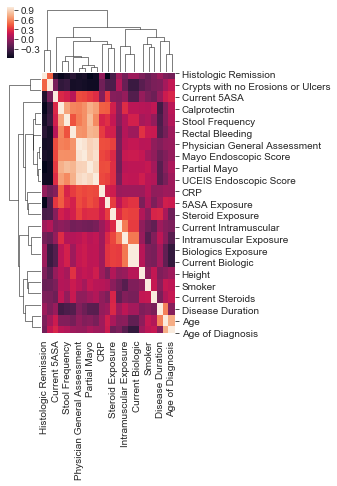

In [29]:
#Perform spearman correlations on each metadata variable
corr = newdf.corr(method='spearman')
ax=sns.clustermap(corr,figsize=(3,6))
#plt.savefig('UC40_Spearman_correlation_metadata_heatmap_final.pdf',bbox_inches='tight')

##### Compare compositions of metaproteome from human proteins by IBD subtypes and activity

In [148]:
#Load in necessary data
df = pd.read_csv('./MGDB_Proteomics/All_proteins_normalized_MGDBFinal.csv',index_col='Master Protein', low_memory=False)
df3 = pd.read_csv('../UC_Severity/pDB_Proteomics/2Search/CSVs/NormalizedDataAll.txt', sep = '\t', index_col="datarest$ProteinID")

protein_ann = pd.read_csv('./Metagenomics/MGDB/MGDB_Full_Protein_Annotations_AllProteomic_hits2.csv')
protein_meta = pd.read_csv('./Metagenomics/MGDB/UC40_Full_Protein_Annotations_All_hitsV2.csv')

meta = pd.read_csv('./Combined_Metadata_Allomics_MP_V1.txt', sep = '\t', index_col = 'id')
meta3 = pd.read_csv('../UC_Severity/UC_MP_Emperor_Map.txt',sep ='\t', index_col = 'id')

In [149]:
df2=df.merge(protein_ann,left_index=True,right_on='queryID',how='left')
df4=df3.merge(protein_meta,left_index=True,right_on='queryID',how='left')

In [150]:
#Remove less certain proteins:
df2=df2[df2['Phylum']!='unknown']
df2=df2[~df2['Phylum'].isna()]

df4=df4[df4['Phylum']!='unknown']
df4=df4[~df4['Phylum'].isna()]


#Create a column for Human vs microbial origin
Human_Prot=[]
for i in df2['Phylum']:
    if i == 'Chordata':
        Human_Prot.append('Human')
    else:
        Human_Prot.append('Microbial')
        
Human_Prot2=[]
for i in df4['Phylum']:
    if i == 'Chordata':
        Human_Prot2.append('Human')
    else:
        Human_Prot2.append('Microbial')
                           
df2['Origin'] = Human_Prot
df4['Origin'] = Human_Prot2

In [151]:
#Make separate metadata for healthy patients because they won't have activity
meta2 = meta[meta["Relative_Activity"] != 'Missing']
meta2.index = meta2.index.astype('str')

#Make lists of patients within categories of interest
meta2.index = meta2.index.astype('str')

#IBD200 only
#Make lists of patient groups
UC_patients = list(meta2[meta2['Diagnosis'] == 'UC'].index.astype('str'))
Healthy_controls = list(meta[meta['Diagnosis'] == 'Healthy_control'].index.astype('str'))
CD_patients =  list(meta[meta['Diagnosis'] == 'CD'].index.astype('str'))

Colonic_CD = list(meta2[(meta2['Diagnosis'] == 'CD') & (meta2['Location'] == 'Colonic')].index.astype('str'))
Ileal_CD = list(meta2[(meta2['Diagnosis'] == 'CD') & (meta2['Location'] == 'Ileal')].index.astype('str'))
Ileocolonic_CD = list(meta2[(meta2['Diagnosis'] == 'CD') & (meta2['Location'] == 'Ileocolonic')].index.astype('str'))

#IBD 200 only
#Remove samples missing from the original dataframe
UC_patients = list(set(UC_patients) & set(df.columns))
Healthy_controls = list(set(Healthy_controls) & set(df.columns))
CD_patients = list(set(CD_patients) & set(df.columns))
Colonic_CD = list(set(Colonic_CD) & set(df.columns))
Ileal_CD = list(set(Ileal_CD) & set(df.columns))
Ileocolonic_CD = list(set(Ileocolonic_CD) & set(df.columns))

#IBD 200 only
#Resort the samples by the activity index
UC_patients=list(meta2.loc[UC_patients].sort_values('Relative_Activity').index.astype('str'))
Colonic_CD=list(meta2.loc[Colonic_CD].sort_values('Relative_Activity').index.astype('str'))
Ileal_CD=list(meta2.loc[Ileal_CD].sort_values('Relative_Activity').index.astype('str'))
Ileocolonic_CD=list(meta2.loc[Ileocolonic_CD].sort_values('Relative_Activity').index.astype('str'))

In [152]:
UC_Cohort1 = list(meta3.sort_values('Relative_Activity_Index').index)

In [153]:
Activity_cat=[]
for i in meta3['partial_Mayo']:
    try:
        a = float(i)
        if a < 3:
            Activity_cat.append('Low')
        elif a <6:
            Activity_cat.append('Moderate')
        elif a <11:
            Activity_cat.append('High')
        else:
            Activity_cat.append('not applicable')
    except ValueError:
        Activity_cat.append('not applicable')
    
meta3['Activity_Level'] = Activity_cat

In [155]:
#Combine the metadata
combined_meta = pd.concat([meta3,meta],join='inner')

#Change the indexes to contain dataset ID
df4['index_wdataset'] = df4.index.astype(str) + 'UC40'
df2['index_wdataset'] = df2.index.astype(str) + 'IBD200'
df4.index = df4['index_wdataset']
df2.index = df2['index_wdataset']

#For origin plots:
cols = ['Origin','Phylum']
df2_key = df2[cols]
df4_key = df4[cols]
ind_key = pd.concat([df4_key,df2_key])

#Marge data together
df_merged = df2.merge(df4, left_index=True, right_index =True,how='outer')
#df_merged.replace(np.nan,0,inplace=True)

#Combine origin columns when one is null
df_merged['Origin'] = np.where(df_merged['Origin_y'].isnull(), df_merged['Origin_x'],df_merged['Origin_y'])


In [160]:
col_order=['Low','Moderate','High']
lists = [UC_Cohort1,UC_patients,CD_patients]

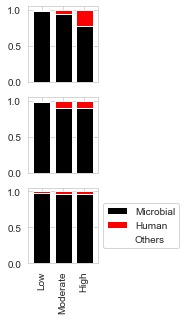

In [162]:
PlotByCategory_MultiSampleGroups2(df=df_merged,lists=lists,Taxa_col='Origin',
                                 category='Activity_Level',
                                 metadata=combined_meta,display_number=2,
                                 save_descrip='Bothdatasets_MP_Origin_Diagnosis_ActivityLevel_Final',
                                 human="True",col_order=col_order)

##### Correlating individual meta -omic features to severity states

In [332]:
###LOAD DATA

#Metaproteomic abundances from first cohort of patients:
#df = pd.read_csv('../UC_Severity/pDB_Proteomics/2Search/CSVs/NormalizedDataAll.txt', sep = '\t', index_col="datarest$ProteinID")
#meta = pd.read_csv('../UC_Severity/UC_MP_Emperor_Map.txt',sep ='\t', index_col = 'id')

##WARNING - METAGENOMIC DATA IS LARGE AND MAY TAKE SIGNIFICANT COMPUTING TIME
#Metagenomic gene counts from first cohort of patients:
#df=pd.read_csv('./UC40_Salmon_CPMs.csv)
#meta = pd.read_csv('../UC_Severity/UC_MP_Emperor_Map.txt',sep ='\t', index_col = 'id')

#Metabolomic abundaces from first cohort of patients:
#df = pd.read_csv('../UC_Severity/Metabolomics/StandardizedMzMIne2020Rerun/UC40_MB_Table_normalized.txt',
                #sep='\t',index_col='#OTU ID')
#meta = pd.read_csv('../UC_Severity/UC_MP_Emperor_Map.txt',sep ='\t', index_col = 'id')

##Metaproteomic data from second cohort of patients:
#df = pd.read_csv('./MGDB_Proteomics/All_proteins_normalized_MGDBFinal.csv',index_col='Master Protein')
#meta = pd.read_csv('./Combined_Metadata_Allomics_MP_V1.txt', sep = '\t', index_col = 'id')

##Metabolomics data from second cohort of patients:
df = pd.read_csv('./Metabolomics/MB_Standardized_Table_Normalized_Final.txt', sep = '\t', index_col = '#OTU ID')
meta = pd.read_csv('./Combined_Metadata_Allomics_MB_V2.txt',sep='\t',index_col='#SampleID')

##Metagenomic data from second cohort of patients:
#df = pd.read_csv('./Metagenomics/Salmon_CPMs.csv',index_col='Name')
#meta = pd.read_csv('./Combined_Metadata_Allomics_MG_V1.txt', sep = '\t',index_col = '#SampleID')

meta.index = meta.index.astype('str')

In [333]:
#Make lists of patients within categories of interest

###SECOND COHORT ONLY
meta2=meta

#Make lists of patient groups
UC_patients = list(meta2[meta2['Diagnosis'] == 'UC'].index.astype('str'))
Healthy_controls = list(meta[meta['Diagnosis'] == 'Healthy_control'].index.astype('str'))
Colonic_CD = list(meta2[(meta2['Diagnosis'] == 'CD') & (meta2['Location'] == 'Colonic')].index.astype('str'))
Ileal_CD = list(meta2[(meta2['Diagnosis'] == 'CD') & (meta2['Location'] == 'Ileal')].index.astype('str'))
Ileocolonic_CD = list(meta2[(meta2['Diagnosis'] == 'CD') & (meta2['Location'] == 'Ileocolonic')].index.astype('str'))

###SECOND COHORT ONLY
#Remove samples missing from the original dataframe
UC_patients = list(set(UC_patients) & set(df.columns))
Healthy_controls = list(set(Healthy_controls) & set(df.columns))
Colonic_CD = list(set(Colonic_CD) & set(df.columns))
Ileal_CD = list(set(Ileal_CD) & set(df.columns))
Ileocolonic_CD = list(set(Ileocolonic_CD) & set(df.columns))

CD = Colonic_CD + Ileocolonic_CD + Ileal_CD

###SECOND COHORT ONLY
#Resort the samples by the activity index
UC_patients=list(meta2.loc[UC_patients].sort_values('Relative_Activity').index.astype('str'))
Colonic_CD=list(meta2.loc[Colonic_CD].sort_values('Relative_Activity').index.astype('str'))
Ileal_CD=list(meta2.loc[Ileal_CD].sort_values('Relative_Activity').index.astype('str'))
Ileocolonic_CD=list(meta2.loc[Ileocolonic_CD].sort_values('Relative_Activity').index.astype('str'))

CD=list(meta2.loc[CD].sort_values('Relative_Activity').index.astype('str'))

In [334]:
###ONLY For metabolite averages:
MB_ann1 = pd.read_csv('./Metabolomics/Qemistree_IDs.txt',sep='\t')
MB_ann2 = pd.read_csv('../UC_Severity/Metabolomics/StandardizedMzMIne2020Rerun/UC40_MB_Annotations.txt',sep='\t')

##FIRST COHORT:
patients=list(df.columns)

#df['#OTU ID']=df.index

#Change metabolite ID columns to strings
MB_ann1['rowid']=MB_ann1['rowid'].astype('str')
MB_ann2['rowID']=MB_ann2['rowID'].astype('str')

df.index=df.index.astype('str')

#Add annotation information for metabolites
#SECOND COHORT:
df2=df.merge(MB_ann1,left_index=True,right_on='rowid')
#FIRST COHORT:
#df2=df.merge(MB_ann2,left_index=True,right_on='rowID')

#Find averages of r-values within checmical classes
##SECOND COHORT BY TYPE:
df2 = df2[CD].groupby([df2['direct_parent']]).mean()
##FIRST COHORT:
#df2 = df2[patients].groupby([df2['direct_parent']]).mean()

#Remove 0s from metabolomics data when calculting spearman correlations
df2.replace(np.nan,0,inplace=True)
df = df2

In [335]:
###SECOND COHORT ONLY
#Subset dataframe to only patients of interest in lists above:

#df = df[UC_patients]
df = df[CD]

In [336]:
##USED CDAI as variable for CD patient correlations, partial_Mayo for UC

LinearRegressions(df=df,metadata=meta,variable='CDAI')

/Users/rhmills/miniconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rhmills/miniconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/rhmills/miniconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


'Linear regressions performed on CDAI. New dataframe stored as "df_out"'

In [338]:
df_out.to_csv('./IBD200_MB_parent_CDAICorrelations.csv')

##### Top metabolite class correlations to UC disease activity


In [339]:
df_n = pd.read_csv('./IBD200_MB_parent_pMayoCorrelations.csv')
df2 = pd.read_csv('./UC40_MB_parent_pMayoCorrelations.csv')
df3 = pd.read_csv('./IBD200_MB_parent_CDAICorrelations.csv')

In [340]:
#Add a column for which dataset is being represented
df_n['Experiment'] = 'IBD200'
df2['Experiment'] = 'UC40'
df3['Experiment'] = 'IBD200'

df_n['Diagnosis'] = 'UC (Cohort 2)'
df2['Diagnosis'] = 'UC (Cohort 1)'
df3['Diagnosis'] = 'CD (Cohort 2)'

In [341]:
#Combine UC datasets
interest_columns = ['Experiment', 'direct_parent', 'rvalue', 'Diagnosis']
combine_df = pd.concat([df_n,df2],names = interest_columns)

/Users/rhmills/miniconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [342]:
combine_df = combine_df[interest_columns]
combine_df['chemical_class'] = 'direct_parent'

#Combine chemicals by rvalues to IBD severity
combine_r = combine_df['rvalue'].groupby([combine_df['direct_parent']]).sum()

#Drop non-compounds
combine_r.drop('partial_Mayo',inplace=True)
combine_r.drop('SMILE parse error',inplace=True)

#Identify top correlations to UC
TopCorrelations=list(combine_r.nlargest(10).index)
BottomCorrelations=list(combine_r.nsmallest(10).index)

#Make final combined df to display UC cohorts and CD patients
combine_df2 = pd.concat([df_n,df2,df3],names = interest_columns)

/Users/rhmills/miniconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


In [373]:
df_melt2.index=df_melt2['direct_parent']
df_melt2['combinedr']=combine_r

In [365]:
#Melt into longform dataframe
interest_cols = ['direct_parent', 'Experiment','Diagnosis']
df_melt = pd.melt(combine_df2, value_vars = 'rvalue', id_vars = interest_cols)

#Isolate top correlations
df_melt2 = df_melt[df_melt['direct_parent'].isin(TopCorrelations)]
df_melt3 = df_melt[df_melt['direct_parent'].isin(BottomCorrelations)]

df_melt2.index=df_melt2['direct_parent']
df_melt2['combinedr']=combine_r

df_melt3.index=df_melt3['direct_parent']
df_melt3['combinedr']=combine_r

df_melt3.sort_values('combinedr',inplace=True)
df_melt2.sort_values('combinedr',ascending=False,inplace=True)

/Users/rhmills/miniconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/rhmills/miniconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/rhmills/miniconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [371]:
#Manual reordered the cohorts to fit color scheme
#df_melt2.to_csv('./Metabolomics_UC_class_avgs_top.csv')
#df_melt3.to_csv('./Metabolomics_UC_class_avgs_bot.csv')

df_melt2=pd.read_csv('./Metabolomics_UC_class_avgs_top.csv')
df_melt3=pd.read_csv('./Metabolomics_UC_class_avgs_bot.csv')

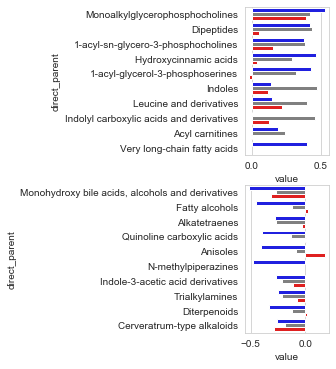

In [372]:
fig, axes = plt.subplots(figsize=(1.5,6),nrows=2)
ax1 = sns.barplot(x = 'value', y = 'direct_parent',ax=axes[1], hue = 'Diagnosis',palette=['blue','gray','red'], data = df_melt3).get_legend().remove()
ax2 = sns.barplot(x = 'value', y = 'direct_parent',ax=axes[0], hue = 'Diagnosis',palette=['blue','gray','red'], data = df_melt2)#.yaxis.tick_right()

axes[0].legend().remove()
plt.savefig('./MetabolomeClass_normalized_top_correlationsbymean_to_Activity_vert_redo.pdf',bbox_inches="tight")


##### Annotate dataframes

In [ ]:
##Load correlations to IBD severity:

#df_n = pd.read_csv('./pMayo_correlations_MGDBMP_naMask.csv', index_col = 'Master Protein')
#df_n = pd.read_csv('./pMayo_correlations_MGDBMP_naMask_UC40.csv', index_col = 'datarest$ProteinID')
#df_n = pd.read_csv('./CDAI_Colonic_correlations_MGDB_naMask.csv', index_col = 'Master Protein')
#df_n = pd.read_csv('./CDAI_Ileocolonic_correlations_MGDB_naMask.csv', index_col = 'Master Protein')
#df_n = pd.read_csv('./CDAI_Ileal_correlations_MGDB_naMask.csv', index_col = 'Master Protein')
#df_n = pd.read_csv('./CDAI_correlations_MGDB_naMask.csv', index_col = 'Master Protein')
#df_n = pd.read_csv('./CDAI_correlations_MGDB_naMask.csv', index_col = 'Master Protein')


#df_n = pd.read_csv('./Metagenomics/pMayo_UC40_correlations_MG_naMask_combined.csv')
#df_n = pd.read_csv('./Metagenomics/pMayo_correlations_MG_naMask.csv', index_col='Name')
#df_n = pd.read_csv('./Metagenomics/CDAI_Colonic_correlations_MG_naMask.csv', index_col='Name')
#df_n = pd.read_csv('./Metagenomics/CDAI_Ileal_correlations_MG_naMask.csv', index_col='Name')
#df_n = pd.read_csv('./Metagenomics/CDAI_Ileocolonic_correlations_MG_naMask.csv', index_col='Name')
df_n = pd.read_csv('./Metagenomics/CDAI_correlations_MG_naMask_combined.csv', index_col='Name')

In [ ]:
##Load protein/gene annotation information

#IBD200 Protein Annotation Information
#MP
#protein_ann = pd.read_csv('./Metagenomics/MGDB/MGDB_Full_Protein_Annotations_AllProteomic_hits2.csv')
#MG
protein_ann = pd.read_csv('./Metagenomics/MGDB/MGDB_Full_Protein_Annotations2.txt', sep='\t')

In [ ]:
##Original UC40 Metaproteomics annotations

#protein_meta = pd.read_csv('./Metagenomics/MGDB/UC40_Full_Protein_Annotations_All_hitsV2.csv')
#protein_meta = pd.read_csv('../UC_Severity/Annotations/UniKB_Taxa_ghostKO_Merge.csv')

In [ ]:
##For UC40 only
#protein_ann = protein_meta2

#Others
protein_ann.index = protein_ann['queryID']

In [ ]:
df_n = df_n.merge(protein_ann, left_index=True, right_index=True, how='left')
len(df_n)

In [ ]:
##Annotate and save dataframe
#df_n.to_csv('./CDAI_correlations_MG_naMask_annotated.csv')

##### Identify the biases in gene and protein level data for identifying taxa and functions related to severity within the different subtypes of IBD

In [19]:
#UC40
df_m40 = pd.read_csv('./pMayo_correlations_MG_MGDB_annotated_UC40.csv', index_col=0)
df_n40 = pd.read_csv('./pMayo_correlations_MP_MGDB_annotated_UC40.csv', index_col=0)

#Second cohort data:
df_n3 = pd.read_csv('./pMayo_correlations_MP_MGDB_annotated.csv', index_col = 0)
df_m3 = pd.read_csv('./pMayo_correlations_MG_MGDB_annotated.csv', index_col = 0)
df_n5 = pd.read_csv('./CDAI_correlations_MP_naMask_annotated.csv', index_col = 0)
df_m5 = pd.read_csv('./CDAI_correlations_MG_naMask_annotated.csv', index_col = 0)


#Supplemental figures generated with these dataframes subsetting data by CD subtypes
#df_n = pd.read_csv('./CDAI_Colonic_correlations_MP_MGDB_annotated.csv', index_col = 0)
#df_m = pd.read_csv('./CDAI_Colonic_correlations_MG_naMask_annotated.csv', index_col = 0)
#df_n2 = pd.read_csv('./CDAI_Ileal_correlations_MP_MGDB_annotated.csv', index_col = 0)
#df_m2 = pd.read_csv('./CDAI_Ileal_correlations_MG_naMask_annotated.csv', index_col = 0)
#df_n4 = pd.read_csv('./Ileolcolonic_CDAI_correlations_MP_annotated.csv', index_col = 0)
#df_m4 = pd.read_csv('./CDAI_Ileocolonic_correlations_MG_naMask_annotated.csv', index_col = 0)



In [31]:
df_dict = {'UC Cohort 1 (MP)':df_n40,'UC Cohort 2 (MP)':df_n3,
           'CD (MP)':df_n5}

'New plot saved.'

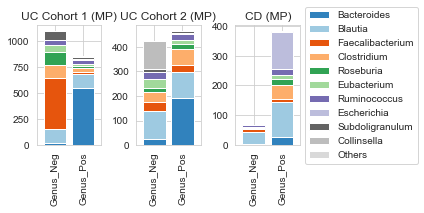

In [21]:
TaxaRatioCompareSigLevelGroups(df_dict,sig_level=0.3,Taxa_col='Genus', save_descrip="UCswCD_MDB_MP_r03_sprc60_Genera_NoRelative_smaller3",human="False",relative="False", 
                               variable='Genus',Sparsity=0.60,display_number=10)

##### Compare the ratios of significant proteins to significant genes

In [23]:
#Create a new dictionary including the metagenomic correlations
df_dict = {'UC Cohort 1 (MP)':df_n40,'UC Cohort 2 (MP)':df_n3,
           'CD (MP)':df_n5,'UC Cohort 1 (MG)':df_m40,'UC Cohort 2 (MG)':df_m3,'CD (MG)':df_m5}

In [24]:
#To remove human proteins from all dataframes
for i in df_dict:
    df_dict[i] = df_dict[i][df_dict[i]['Genus'] != 'Homo']

In [25]:
#Comparing only significant proteins
TaxaLogRatioCompareSigLevelGroupsCombine(df_dict,sig_level=0.3,Taxa_col='Genus',human="True",
                                         variable='Genus',MinCount=10,Sparsity=0.6,compareall="False")

'All ratio dataframes combined into "ratio_dict".'

In [26]:
#Concatenate ratio data into one dataframe
ratio_df2=pd.concat(ratio_dict)

#Create separate lists for most commonly found genera within significant proteins or genes
top_mp_genera = ['Bacteroides','Blautia','Faecalibacterium','Clostridium','Roseburia','Eubacterium',
                'Ruminococcus','Escherichia','Subdoligranulum','Collinsella']

top_mg_genera = ['Bacteroides','Roseburia','Blautia','Anaerostipes','Escherichia','Flavonifractor',
                 'Fusicatenibacter','Clostridium','Lachnoclostridium']

#Subset out ratio dataframes to only include these top genera for plot
top_mp_ratios = ratio_df2[ratio_df2['Genus'].isin(top_mp_genera)]
top_mg_ratios = ratio_df2[ratio_df2['Genus'].isin(top_mg_genera)]

#Optional - manually sort the dataframes by top genera and cohorts to align with manuscript figures:
#top_mp_ratios.to_csv('./TopMPGenus_ratios.csv')
#top_mg_ratios.to_csv('./TopMGGenus_ratios.csv')


In [29]:
#Reordered for being in order of genera with most MP or MG correlations
top_mp_ratios = pd.read_csv('./TopMPGenus_ratios.csv')
#top_mg_ratios = pd.read_csv('./TopMGGenus_ratios.csv')

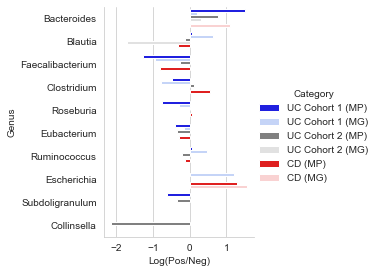

In [30]:
#Make the plot
plot1 = sns.catplot(x="Log(Pos/Neg)", y = "Genus",hue="Category",kind="bar",palette=['blue','#BDD0FF','gray','#E1E1E1','red','#ffcccc'],
                    data=top_mp_ratios,
                    height=3.9,aspect=1.08)

#Option to save the plot
#plot1.savefig('./MGDB_wMG_Top10MPGenus_Log10_Plot_r03_sprc06_10min.pdf')

##### Identify the types of proteins overrepresented in <i> Bacteroides </i> positive associations to UC activity

In [ ]:
df_dict = {'UC Cohort 1 (MP)':df_n40,'UC Cohort 2 (MP)':df_n3,
           'CD (MP)':df_n5}

In [35]:
#Filter to leave only the Bacteroides proteins
for i in df_dict:
    df_dict[i] = df_dict[i][df_dict[i]['Genus'] == 'Bacteroides']

In [36]:
#Identify the functional differences (via kegg functional categories) in significant proteins and all other proteins within each genera:

TaxaLogRatioCompareSigLevelGroupsCombine(df_dict,sig_level=0.3,Taxa_col='KEGG_Functional_Category',
                                         human="True", compareall="True",
                                         variable='Genus',MinCount=10,Sparsity=0.95)

'All ratio dataframes combined into "ratio_dict".'

In [37]:
ratio_df = pd.concat(ratio_dict)
ratio_df2 = ratio_df.sort_values(by=["Category","Log(Pos/Neg)"], ascending=[False,False])

In [40]:
#Save and reorder by the top UC Cohort 1 findings:
#ratio_df2.to_csv('./Bacteroides_r03vs_sprct95_KEGGRatios.csv')
ratio_df2 = pd.read_csv('./Bacteroides_r03vs_sprct95_KEGGRatios.csv')

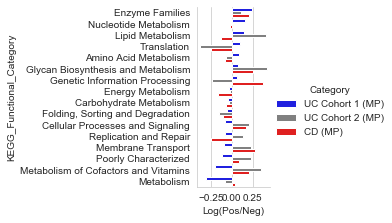

In [41]:
plot1 = sns.catplot(x="Log(Pos/Neg)", y = "KEGG_Functional_Category",hue="Category",kind="bar",palette=['blue','gray','red'],
                    data=ratio_df2,
                    height=3.2,aspect=1.5)#,order=combine_list)
#plot1.savefig('./MGDB_MP_Bacteroides_Log10_KEGGPlot_r03_sprc95_10min_small.pdf')

Specifically plot out the ratios of peptidases and proteases correlated with disease severity

In [52]:
#Add a new column for when the protein name contains peptidase or protease
for i in df_dict:
    df_dict[i]['Peptidase'] = np.where(df_dict[i]['Protein names'].str.contains('peptidase|protease',case=False) == True, 'Peptidase', 'Not Peptidase')


In [59]:
#Identify the differences in significant vs not significant peptidases
TaxaLogRatioCompareSigLevelGroupsCombine(df_dict,sig_level=0.1,Taxa_col='Peptidase',
                                         human="True", compareall="True",
                                         variable='Peptidase',MinCount=10,Sparsity=0.95)

'All ratio dataframes combined into "ratio_dict".'

In [60]:
pept_ratios = pd.concat(ratio_dict)

In [62]:
##Optional: manually reordered to have data presented in order of manuscript:
#pept_ratios.to_csv('./Bacteroides_PeptidaseProteaser03_sprct95_ratios.csv')
pept_ratios=pd.read_csv('./Bacteroides_PeptidaseProteaser03_sprct95_ratios.csv')

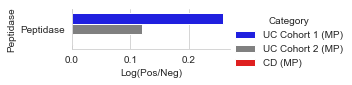

In [63]:
plot1 = sns.catplot(x="Log(Pos/Neg)", y = "Peptidase",hue="Category",kind="bar",palette=['blue','gray','red'],
                    data=pept_ratios,
                    height=1.25,aspect=3)
#plot1.savefig('./MGDB_MP_BacteroidesPeptidasesProteases_Log10_r03_sprc95_small.pdf')

##### Identify Bacteroides MG abundance & composition of each Bacteroides species

In [64]:
#Data
df = pd.read_csv('./Metagenomics/Salmon_CPMs.csv',index_col='Name')
df2 = pd.read_csv('../UC_Severity/Genomics/Shotgun/Salmon_CPMs.csv', index_col="Name")

In [65]:
#Patient metadata
meta = pd.read_csv('./Combined_Metadata_Allomics_MG_V1.txt', sep = '\t',index_col = 'id')
meta2 = pd.read_csv('../UC_Severity/UC_MP_Emperor_Map.txt',sep ='\t', index_col = 'id')

In [66]:
#Protein metadata
MG_ann = pd.read_csv('./Metagenomics/MGDB/MGDB_Full_Protein_Annotations.txt', sep = '\t')
MG_ann2 = pd.read_csv('../UC_Severity/Annotations/UniKB_Taxa_ghostKO_Merge.csv')

In [67]:
#Isolate list of UC patients from cohort 1 and sort by activity
UC_patients2 = list(meta2.index)
UC_patients2 = list(set(UC_patients2) & set(df2.columns))
UC_patients2=list(meta2.loc[UC_patients2].sort_values('partial_Mayo').index)

#Isolate list of UC patients from cohort 2 and sort by activity
UC_patients = list(meta[meta['Diagnosis'] == 'UC'].index)
UC_patients = list(set(UC_patients) & set(df.columns))
UC_patients=list(meta.loc[UC_patients].sort_values('partial_Mayo').index)

#Remove duplicates
MG_ann = MG_ann.loc[list(MG_ann['queryID'].drop_duplicates().index)]
MG_ann2 = MG_ann2.loc[list(MG_ann2['queryID'].drop_duplicates().index)]

#Merge data with annotation information
df_merge = df.merge(MG_ann, left_index = True, right_on = 'queryID', how = 'left')
df_merge2 = df2.merge(MG_ann2, left_index = True, right_on = 'queryID', how = 'left')

#List of sample names
samples = list(df.columns)
samples2 = list(df2.columns)

#Create dataframes for genus level sums of genes
df_g = df_merge[samples].groupby(df_merge['Genus']).agg('sum')
df_g2 = df_merge2[samples2].groupby(df_merge2['Genus']).agg('sum')


#Pull out the reads for each Bacteroides species
df_s = df_merge[df_merge['Genus'] == ' g__Bacteroides']
df_s2 = df_merge2[df_merge2['Genus'] == ' g__Bacteroides']
#Aggregate the species and overwrite the dataframe
df_s = df_s[samples].groupby(df_s['Species']).agg('sum')
df_s2 = df_s2[samples2].groupby(df_s2['Species']).agg('sum')



In [73]:
#Combine both datasets
dfs_merge = df_s.merge(df_s2, left_index=True,right_index=True, how='outer')
dfs_merge.replace(np.nan,0,inplace=True)
#Change index
dfs_merge['Species'] = dfs_merge.index

In [72]:
#Combine both dataset metadata files
combined_meta = pd.concat([meta,meta2],join='inner')
lists = [UC_patients2,UC_patients]

In [74]:
#Create a 3 tiered activity level indication
Activity_cat=[]
for i in combined_meta['partial_Mayo']:
    try:
        a = float(i)
        if a < 3:
            Activity_cat.append('Low')
        elif a <6:
            Activity_cat.append('Moderate')
        elif a <11:
            Activity_cat.append('High')
        else:
            Activity_cat.append('not applicable')
    except ValueError:
        Activity_cat.append('not applicable')
    
combined_meta['Activity_Level'] = Activity_cat

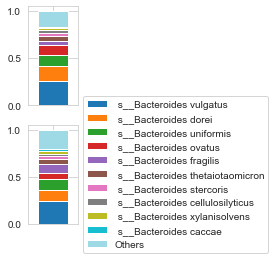

In [77]:
#Plot stacked barplots
PlotByCategory_MultiSampleGroups(df=dfs_merge,lists=lists,Taxa_col='Species',category='TAXON_ID',
                                 metadata=combined_meta,display_number=10, size=4,
                                 save_descrip='Bothdatasets_MGBacteroidesSpecies_comp_UC_OverallAvg_top10_final',
                                 human="True")

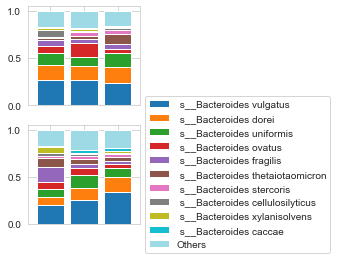

In [78]:
PlotByCategory_MultiSampleGroups(df=dfs_merge,lists=lists,Taxa_col='Species',category='Activity_Level',
                                 metadata=combined_meta,display_number=10,size=9,
                                 save_descrip='Bothdatasets_MGBacteroidesSpecies_comp_UC_ActivityLevel_Averaged_top10_final',
                                 human="True")

Plot the composition of Bacteroides in overall MG reads

In [95]:
#Identify compositions
df_g4 = df_g2
for j in df_g4:
    df_g4[j] = df_g4[j]/df_g4[j].sum()

df_g3 = df_g
for j in df_g3:
    df_g3[j] = df_g3[j]/df_g3[j].sum()

#Reset indexes
df_g4=df_g4.T.reset_index()
df_g3=df_g3.T.reset_index()

#Change to longform dataframes
df_melt = df_g4.melt(id_vars='index',value_vars=' g__Bacteroides')
df_melt2 = df_g3.melt(id_vars='index',value_vars=' g__Bacteroides')

#Change columns names
df_melt.rename(columns={'index':'Patient ID', 'value':'% MG Composition'}, inplace = True)
df_melt2.rename(columns={'index':'Patient ID', 'value':'% MG Composition'}, inplace = True)

#Subset to only the UC patients in the IBD200 data
df_melt2=df_melt2[df_melt2['Patient ID'].isin(UC_patients)]

df_melt['Diagnosis'] = 'UC'
df_melt2['Diagnosis'] = 'UC'

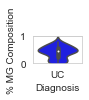

In [97]:
#Make swarm plots to summarize the composition data
fig_width = 2*(4/9)
fig, ax = plt.subplots(figsize = (fig_width,0.5))
sns.violinplot(x='Diagnosis',y='% MG Composition',data=df_melt,palette=['blue']).set(ylim=(0, 1))
plt.savefig('./UC40_BacteroidesMGPrcntages_Swarmplot_final.pdf', bbox_inches='tight')

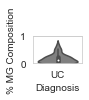

In [99]:
#Make swarm plots to summarize the composition data
fig_width = 2*(4/9)
fig, ax = plt.subplots(figsize = (fig_width,0.5))
sns.violinplot(x='Diagnosis',y='% MG Composition',data=df_melt2,palette=['gray']).set(ylim=(0, 1))
plt.savefig('./IBD200UCpatientsBacteroidesMGPrcntages_final.pdf', bbox_inches='tight')

In [110]:
#Reperform the compositions
df_g3 = df_g
for j in df_g3:
    df_g3[j] = df_g3[j]/df_g3[j].sum()

df_g4 = df_g2
for j in df_g4:
    df_g4[j] = df_g4[j]/df_g4[j].sum()




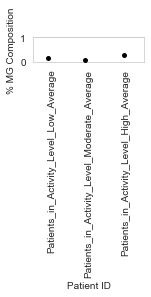

In [113]:
#Use the dotplotcategory function to create plots
DotPlotCategory(df=df_g3,samples=UC_patients,Taxa_col=' g__Bacteroides',
                category='Activity_Level',metadata=combined_meta,
                save_descrip='IBD200_DotPlot_Activity_final',width=9)

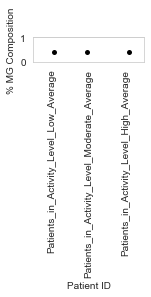

In [114]:
#Use the dotplotcategory function to create plots
DotPlotCategory(df=df_g4,samples=UC_patients2,Taxa_col=' g__Bacteroides',
                category='Activity_Level',metadata=combined_meta,
                save_descrip='UC40_DotPlot_Activity_final',width=9)

##### Compare correlations to activity of Bacteroides proteases by species

In [33]:
#Load in the correlation data
df_n40 = pd.read_csv('./pMayo_correlations_MP_MGDB_annotated_UC40.csv', index_col=0)
df_n3 = pd.read_csv('./pMayo_correlations_MP_MGDB_annotated.csv', index_col = 0)

In [34]:
#Subset for Bacteroides
df_n40=df_n40[df_n40['Genus']=='Bacteroides']

#Pull out the enzymes and proteases, then concatenate them to one dataframe
df_n40_enz = df_n40[df_n40['KEGG_Functional_Category'] == 'Enzyme Families'] 
df_n40_pept = df_n40[df_n40['Protein names'].str.contains('peptidase|protease',case=False)==True]
df_n40_all = pd.concat([df_n40_pept,df_n40_enz])

df_n3=df_n3[df_n3['Genus']=='Bacteroides']
df_n3_enz = df_n3[df_n3['KEGG_Functional_Category'] == 'Enzyme Families'] 
df_n3_pept = df_n3[df_n3['Protein names'].str.contains('peptidase|protease',case=False)==True]
df_n3_all = pd.concat([df_n3_pept,df_n3_enz])

#Compile the correlations by both the species and the cohort, start by making new column
df_n40_all['Species_cohort']=df_n40_all['Species']+" (UC Cohort 1)"
df_n3_all['Species_cohort']=df_n3_all['Species']+" (UC Cohort 2)"

#Identify the columns of interest
Columns = ['Species_cohort','rvalue','Protein names']
#Subset the columns of interest
UC1=df_n40_all[Columns]
UC2=df_n3_all[Columns]
#Concatenate the two datasets
UC_cat=pd.concat([UC1,UC2])

#Aggregate by the sum of the correlations within each protein of each species
UC_cat['sumbby']=UC_cat['Species_cohort']+UC_cat['Protein names']
groupcols=['Protein names','Species_cohort']
UC_cat2=UC_cat.groupby(groupcols)['rvalue'].sum().reset_index()

#Pivot the table for visualization
Bprot_rtable=UC_cat2.pivot(index='Protein names',columns='Species_cohort',values='rvalue')


In [6]:
#Determine bacteria order by species abundance
Abund_bac=["Bacteroides vulgatus (UC Cohort 1)","Bacteroides vulgatus (UC Cohort 2)","Bacteroides dorei (UC Cohort 1)","Bacteroides dorei (UC Cohort 2)",
"Bacteroides uniformis (UC Cohort 1)","Bacteroides uniformis (UC Cohort 2)",
"Bacteroides ovatus (UC Cohort 1)","Bacteroides ovatus (UC Cohort 2)",
"Bacteroides fragilis (UC Cohort 1)","Bacteroides fragilis (UC Cohort 2)",
"Bacteroides thetaiotaomicron (UC Cohort 1)","Bacteroides thetaiotaomicron (UC Cohort 2)"]

abund_df=Bprot_rtable[Abund_bac]
abund_df=abund_df.dropna(axis=0,how='all')
abund_df['Number_missing']=abund_df.isnull().sum(axis=1)
abund_df=abund_df[abund_df['Number_missing']<11].drop(columns='Number_missing')
abund_df=abund_df.drop(index='Deleted.')

In [7]:
#Determine protein order by molecular function
proteins=abund_df.index
dfall=pd.concat([df_n3_all,df_n40_all])
cols=['Gene ontology (molecular function)','Protein names']
prot_funct_df=dfall[cols].drop_duplicates()
prot_funct_df=prot_funct_df[prot_funct_df['Protein names'].isin(proteins)]
prot_order=list(prot_funct_df.sort_values(by='Gene ontology (molecular function)')['Protein names'])

In [8]:
#Manually sorted by the class type activities of each protease
#prot_funct_df.sort_values(by='Gene ontology (molecular function)').to_csv('./abundbacteroidesproteases_molfunct.csv')

prot_order=["Dipeptidase (EC 3.4.-.-)",
"Dipeptidyl aminopeptidase IV",
"Dipeptidyl peptidase IV",
"Dipeptidyl peptidase IV N-terminal domain protein (Fragment)",
"Dipeptidyl-peptidase 7 (DPP7) (EC 3.4.14.-)",
"Dipeptidyl-peptidase III (EC 3.4.14.4)",
"Peptidase S9A/B/C family catalytic domain protein",
"Peptidase, S9A/B/C family, catalytic domain protein (EC 3.4.-.-)",
"Prolyl oligopeptidase family protein",
"Prolyl tripeptidyl peptidase (EC 3.4.14.12)",
"Protease Do",
"Putative Tricorn-like protease",
"Serine protease",
"Signal peptidase I (EC 3.4.21.89)",
"Signal peptide peptidase SppA, 67K type (EC 3.4.-.-)",
"Tricorn protease",
"Tricorn protease homolog (EC 3.4.21.-)",
"Uncharacterized protein",
"Aminopeptidase P domain protein (EC 3.4.-.-)",
"Endothelin-converting enzyme 1 (EC 3.4.24.71)",
"Leucine aminopeptidase",
"Peptidase M16 inactive domain protein",
"Peptidase M16 inactive domain protein (EC 3.4.24.-)",
"Peptidase, M24 family (EC 3.4.-.-)",
"Peptidase, M28 family (EC 3.4.-.-)",
"Putative endothelin-converting enzyme",
"Putative peptidyl-dipeptidase dcp",
"TldD/PmbA family protein",
"Xaa-His dipeptidase (EC 3.4.13.3)",
"Xaa-Pro aminopeptidase (EC 3.4.11.9)",
"Aminopeptidase C",
"Aminopeptidase C (Bleomycin hydrolase)",
"Peptidase C1-like family protein (Fragment)",
"Peptidase C1A papain",
"Aminoacyl-histidine dipeptidase (Cytosol non-specific dipeptidase) (EC 3.4.13.18)",
"Carboxypeptidase regulatory-like domain protein",
"Carboxypeptidase regulatory-like domain protein (TonB-dependent Receptor Plug Domain protein)",
"Cytosol non-specific dipeptidase (EC 3.4.13.18)"]

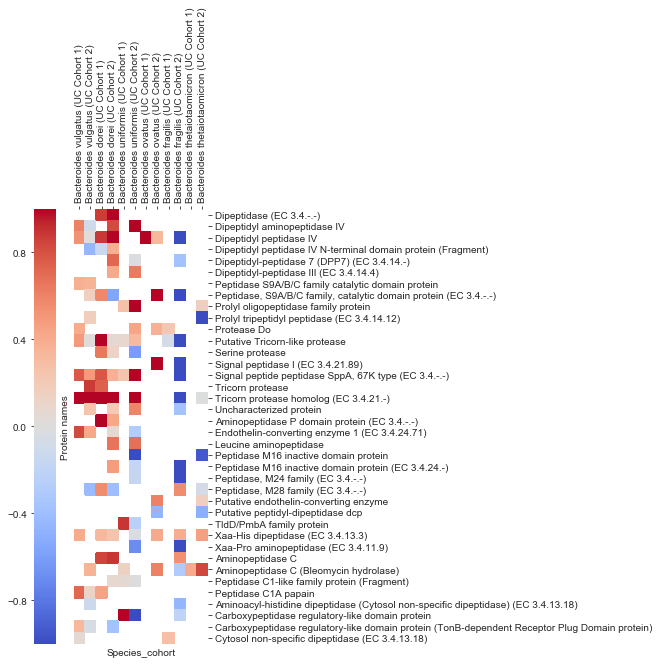

In [10]:
#Reorder the data
abund_df=abund_df.loc[prot_order]

#Create a heatmap of the data
ax=plt.subplots(figsize=(3.2,8))
ax=sns.heatmap(abund_df,cmap='coolwarm',vmax=1,vmin=-1,cbar_kws = dict(use_gridspec=False,location="left"))
ax.tick_params(left=False,bottom=False,right=True, top=True, 
               labelright=True, labeltop=True,labelbottom=False,
               labelleft=False,rotation=0)
plt.xticks(rotation='vertical')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.savefig('Combined_UC_Bacteroides_ProteasesRvaluesSum_HeatmapReds_final.pdf',bbox_inches='tight')

##### Identify patient samples overproducing Bacteroides vulgatus proteases

In [163]:
#Proteases from Bv or Bd overlap
df1 = pd.read_csv('./pMayo_correlations_MP_MGDB_annotated.csv', index_col = 'Master Protein')
df2 = pd.read_csv('./pMayo_correlations_MP_MGDB_annotated_UC40.csv', index_col=0)

In [167]:
#Find the positive correlations
df2 = df2[df2['rvalue'] > 0.3]
df1 = df1[df1['rvalue'] > 0.3]

#Pull out 
species_interest = ['Bacteroides dorei', 'Bacteroides vulgatus']
df2 = df2[df2['Species'].isin(species_interest)]
df1 = df1[df1['Species'].isin(species_interest)]

df1_enz = df1[df1['KEGG_Functional_Category'] == 'Enzyme Families'] 
df1_pept = df1[df1['Protein names'].str.contains('peptidase|protease',case=False)==True]
df1_all = pd.concat([df1_pept,df1_enz])
#IBD200 = set(df1_all['Protein names'])

df2_enz = df2[df2['KEGG_Functional_Category'] == 'Enzyme Families'] 
df2_pept = df2[df2['Protein names'].str.contains('peptidase|protease',case=False)==True]
df2_all = pd.concat([df2_pept,df2_enz])
#UC40 = set(df2_all['Protein names'])

df1_all.index = df1_all.index + 'IBD200'
df2_all.index = df2_all.index + 'UC40'

BvBdProteasesMPdf=pd.concat([df1_all,df2_all])
#Instead only going to match by protease names
#UC40 = set(df2_pept['Protein names'])
#IBD200 = set(df1_pept['Protein names'])

In [187]:
## Bring in metagenomics data

#Data
#df = pd.read_csv('./Metagenomics/Salmon_CPMs.csv',index_col='Name')
#df2 = pd.read_csv('../UC_Severity/Genomics/Shotgun/Salmon_CPMs.csv', index_col="Name")

#Patient metadata
meta = pd.read_csv('./Combined_Metadata_Allomics_MG_V1.txt', sep = '\t',index_col = 'id')
meta2 = pd.read_csv('../UC_Severity/UC_MP_Emperor_Map.txt',sep ='\t', index_col = 'id')
meta2['Proteome_ID'] = meta2.index

#Protein metadata
#MG_ann = pd.read_csv('./Metagenomics/MGDB/MGDB_Full_Protein_Annotations.txt', sep = '\t')
#MG_ann2 = pd.read_csv('../UC_Severity/Annotations/UniKB_Taxa_ghostKO_Merge.csv')

#Isolate list of UC patients from cohort 1 and sort by activity
UC_patients2 = list(meta2.index)
UC_patients2 = list(set(UC_patients2) & set(df2.columns))
UC_patients2=list(meta2.loc[UC_patients2].sort_values('partial_Mayo').index)

#Isolate list of UC patients from cohort 2 and sort by activity
UC_patients = list(meta[meta['Diagnosis'] == 'UC'].index)
UC_patients = list(set(UC_patients) & set(df.columns))
UC_patients=list(meta.loc[UC_patients].sort_values('partial_Mayo').index)

#Remove duplicates
MG_ann = MG_ann.loc[list(MG_ann['queryID'].drop_duplicates().index)]
MG_ann2 = MG_ann2.loc[list(MG_ann2['queryID'].drop_duplicates().index)]

#Merge data with annotation information
df_merge = df.merge(MG_ann, left_index = True, right_on = 'queryID', how = 'left')
df_merge2 = df2.merge(MG_ann2, left_index = True, right_on = 'queryID', how = 'left')

#List of sample names
samples = list(df.columns)
samples2 = list(df2.columns)

#Pull out the reads for each Bacteroides species
df_s = df_merge[df_merge['Genus'] == ' g__Bacteroides']
df_s2 = df_merge2[df_merge2['Genus'] == ' g__Bacteroides']
#Aggregate the species and overwrite the dataframe
df_s = df_s[samples].groupby(df_s['Species']).agg('sum')
df_s2 = df_s2[samples2].groupby(df_s2['Species']).agg('sum')


#Combine both datasets
dfs_merge = df_s.merge(df_s2, left_index=True,right_index=True, how='outer')
dfs_merge.replace(np.nan,0,inplace=True)
#Change index
dfs_merge['Species'] = dfs_merge.index

#Combine both dataset metadata files
combined_meta = pd.concat([meta,meta2],join='inner')

In [198]:
#Subset out species of interest from above
BvBd = [' s__Bacteroides vulgatus',' s__Bacteroides dorei']
BvMGdf = dfs_merge[dfs_merge.index.isin(BvBd)]

#Sum the MG abundances
BvMGdf.loc['sum'] = BvMGdf.sum(axis=0)

#Identify sum of Bacteroides species
samples=set(BvMGdf.columns)&set(combined_meta.index)

#Subset out to only listed samples
BvMGdf2=BvMGdf[samples]
combined_meta2 = combined_meta.loc[samples]
#Change sample names to be compatible with proteome data
BvMGdf2.columns = combined_meta2['Proteome_ID']
#Drop unused samples
BvMGdf2.drop(columns='not_analyzed',inplace=True)
#Rename
BvMGdf2.rename({'sum':'BvandBdMGSum'},axis='index',inplace=True)
#Save and reload for column names error
BvMGdf2.to_csv('./BvBdMGSums2.csv')
#Couldn't figure how to get axis labels proper but this worked to save and load
BvMGdf2 = pd.read_csv('./BvBdMGSums2.csv',index_col='Species')
BvBdProteasesMPdf.loc['BvBdMGSum'] = BvMGdf2.loc['BvandBdMGSum']

#Remove unnecessary data in metadata
combined_meta2.index = combined_meta2['Proteome_ID']
combined_meta2=combined_meta2[combined_meta2.index!='not_analyzed']
combined_meta3=combined_meta2
combined_meta3=combined_meta3[combined_meta3['Proteome_ID']!='not_analyzed']
combined_meta3.index = combined_meta3['Proteome_ID']
combined_meta4 = combined_meta3[combined_meta3['partial_Mayo']!='Missing']
combined_meta4 = combined_meta4[combined_meta4['partial_Mayo']!='Healthy_control']
UC_patients = list(combined_meta4.index)

#Subset out dataframes to overlapping patients
df = BvBdProteasesMPdf[set(UC_patients)&set(BvBdProteasesMPdf.columns)]
combined_meta4 = combined_meta4.loc[combined_meta4.index.isin(set(UC_patients)&set(BvBdProteasesMPdf.columns))]
combined_meta4=combined_meta4.drop_duplicates()
df.loc['Relative_Disease_Activity'] = combined_meta4['Relative_Activity_Index']

dfT=df.T
bvproteases=list(dfT.columns)
bvproteases.remove('BvBdMGSum')
bvproteases.remove('Relative_Disease_Activity')

dfT['MPsum']=dfT[bvproteases].sum(axis=1)
dfT['MPaverage']=dfT[bvproteases].mean(axis=1)
dfT['Relative_Disease_Activity']=dfT['Relative_Disease_Activity'].astype('float')

In [213]:
dfT['BvBdMGSum']=dfT['BvBdMGSum'].astype('float')
dfT['MPsum']=dfT['MPsum'].astype('float')


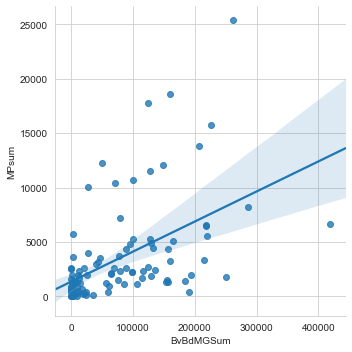

In [214]:
sns.lmplot(x='BvBdMGSum', y='MPsum', data=dfT)
#plot1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.tight_layout()
#plt.savefig('BVMGabund_BVProteaseSum_lmplot.pdf',bbox_inches="tight")

In [ ]:
#dfT.to_csv('./MGvsProteaseAbundances_.csv')

##### Identify strength of associations between disease activity, endoscopic, and histology and Bacteroides protease production


In [43]:
#List of patient samples by BV protease abundance category:
High_overpros = ['H19','L18','H9','59','H5','77', 'H2','H7']
Med_overpros = ['57','H4','193','25']
Low_overpros = ['H10','137','12','H11']
Low_underpros = ['129','8','154']
Med_underpros = ['102','60','138','L7','179','60','L10','132']
High_underpros = ['200','L11','L19','L1','H15','L4','H20']

In [234]:
meta = pd.read_csv('./Combined_metadata_metaproteome_metabolome_v1.txt', sep = '\t', index_col='Proteome_ID')
meta2 = pd.read_csv('../UC_Severity/UC_MP_Emperor_Map.txt',sep ='\t', index_col = 'id')

In [239]:
meta2.rename(columns={'UCEIS_endoscopic_score':'UCEIS'},inplace=True)

meta['Experiment'] = 'IBD200'
meta2['Experiment'] = 'UC40'

cols = ['Experiment','partial_Mayo','UCEIS']

meta = meta[cols]
meta2 = meta2[cols]

meta3 = pd.concat([meta,meta2])
meta3 = meta3[meta3['partial_Mayo'] != 'Missing'] 
meta3 = meta3[meta3['partial_Mayo'] != 'Follow_up_with_MD']
meta3 = meta3[meta3['partial_Mayo'] != 'Healthy_control']

meta3['partial_Mayo'] = meta3['partial_Mayo'].astype('float')

palette = {'IBD200':'gray','UC40':'blue'}

In [242]:
Protease_cat = []
for i in meta3.index:
    if i in High_overpros:
        Protease_cat.append('Overproducer')
    elif i in Med_overpros:
        Protease_cat.append('Overproducer')
    elif i in Low_overpros:
        Protease_cat.append('Overproducer')    
    elif i in Med_underpros:
        Protease_cat.append('Underproducer')
    elif i in Low_underpros:
        Protease_cat.append('Others')
    elif i in High_underpros:
        Protease_cat.append('Underproducer')    
    else:
        Protease_cat.append('Others')    
meta3['Bv Protease Producer Category'] = Protease_cat

[Text(0, 0, 'Others'), Text(0, 0, 'Underproducer'), Text(0, 0, 'Overproducer')]

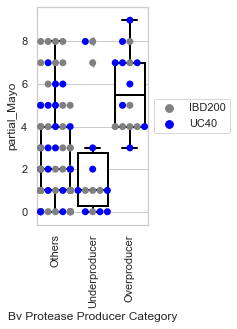

In [243]:
sns.set(rc={'figure.figsize':(2,4)})
sns.set_style("whitegrid")
plot1 = sns.swarmplot(x='Bv Protease Producer Category', y='partial_Mayo',hue='Experiment', palette=palette, data=meta3, size=7)
ax = sns.boxplot(x='Bv Protease Producer Category', y='partial_Mayo',color='white', linewidth='2',data=meta3)
# iterate over boxes
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(6*i,6*(i+1)):
         ax.lines[j].set_color('black')

plot1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plot1.set_xticklabels(plot1.get_xticklabels(),rotation=90)
#plt.savefig('Bv_protease_outliers_analysis_boxplots.pdf', bbox_inches="tight")



Stats on association to disease activity

In [244]:
a = list(meta3[meta3['Bv Protease Producer Category'] == 'Overproducer']['partial_Mayo'])
b = list(meta3[meta3['Bv Protease Producer Category'] == 'Underproducer']['partial_Mayo'])

scipy.stats.ttest_ind(a=a,b=b)

Ttest_indResult(statistic=3.782479069637194, pvalue=0.0007505816369892496)

In [245]:
a = list(meta3[meta3['Bv Protease Producer Category'] == 'Overproducer']['partial_Mayo'])
b = list(meta3[meta3['Bv Protease Producer Category'] == 'Others']['partial_Mayo'])

scipy.stats.ttest_ind(a=a,b=b)

Ttest_indResult(statistic=5.036173141634479, pvalue=2.390131497985491e-06)

In [246]:
a = list(meta3[meta3['Bv Protease Producer Category'] == 'Underproducer']['partial_Mayo'])
b = list(meta3[meta3['Bv Protease Producer Category'] == 'Others']['partial_Mayo'])

scipy.stats.ttest_ind(a=a,b=b)

Ttest_indResult(statistic=-0.25970869519310863, pvalue=0.7956883134787964)

Relationship to protease producing categories and endoscopy

In [247]:
meta4 = meta3[meta3['UCEIS']!='Missing']
meta4['UCEIS']=meta4['UCEIS'].astype('float')

[Text(0, 0, 'Others'), Text(0, 0, 'Underproducer'), Text(0, 0, 'Overproducer')]

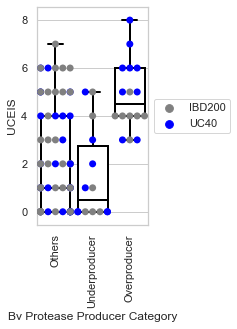

In [248]:
sns.set(rc={'figure.figsize':(2,4)})
sns.set_style("whitegrid")
plot1 = sns.swarmplot(x='Bv Protease Producer Category', y='UCEIS',hue='Experiment', palette=palette, data=meta4, size=7)
ax = sns.boxplot(x='Bv Protease Producer Category', y='UCEIS',color='white', linewidth='2',data=meta4)
# iterate over boxes
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(6*i,6*(i+1)):
         ax.lines[j].set_color('black')

plot1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plot1.set_xticklabels(plot1.get_xticklabels(),rotation=90)
#plt.savefig('Bv_protease_outliers_analysis_boxplots_UCEIS.pdf', bbox_inches="tight")

In [249]:
a = list(meta4[meta4['Bv Protease Producer Category'] == 'Overproducer']['UCEIS'])
b = list(meta4[meta4['Bv Protease Producer Category'] == 'Underproducer']['UCEIS'])

scipy.stats.ttest_ind(a=a,b=b)

Ttest_indResult(statistic=5.291233533028236, pvalue=1.2514208976853215e-05)

In [250]:
a = list(meta4[meta4['Bv Protease Producer Category'] == 'Overproducer']['UCEIS'])
b = list(meta4[meta4['Bv Protease Producer Category'] == 'Others']['UCEIS'])

scipy.stats.ttest_ind(a=a,b=b)

Ttest_indResult(statistic=4.803777892838683, pvalue=6.625328700792065e-06)

In [251]:
a = list(meta4[meta4['Bv Protease Producer Category'] == 'Underproducer']['UCEIS'])
b = list(meta4[meta4['Bv Protease Producer Category'] == 'Others']['UCEIS'])

scipy.stats.ttest_ind(a=a,b=b)

Ttest_indResult(statistic=-0.9403747677770924, pvalue=0.34975416602861975)

Proportions of histological remission in producer categories

In [44]:
meta = pd.read_csv('./Combined_metadata_allomics_hist.txt', sep = '\t', index_col='Proteome_ID')
meta2 = pd.read_csv('../UC_Severity/UC_MP_Emperor_Map_v2_2020.txt',sep ='\t', index_col = 'id')

meta['Experiment'] = 'IBD200'
meta2['Experiment'] = 'UC40'

cols = ['Experiment','partial_Mayo','Geboes_Grade_3_Numeric']

meta = meta[cols]
meta2 = meta2[cols]

meta3 = pd.concat([meta,meta2])

Protease_cat = []
for i in meta3.index:
    if i in High_overpros:
        Protease_cat.append('Overproducer')
    elif i in Med_overpros:
        Protease_cat.append('Overproducer')
    elif i in Low_overpros:
        Protease_cat.append('Overproducer')    
    elif i in Med_underpros:
        Protease_cat.append('Underproducer')
    elif i in Low_underpros:
        Protease_cat.append('Others')
    elif i in High_underpros:
        Protease_cat.append('Underproducer')    
    else:
        Protease_cat.append('Others')

meta3['Bv Protease Producer Category'] = Protease_cat

meta3 = meta3[meta3['Geboes_Grade_3_Numeric']!='not applicable']
meta3['Geboes_Grade_3_Numeric']=meta3['Geboes_Grade_3_Numeric'].astype('float')
meta3 = meta3[meta3['Geboes_Grade_3_Numeric'].isna()==False]


In [45]:
#Categorize patients as having histological remission

hist_rem=[]
for i in meta3['Geboes_Grade_3_Numeric']:
    if i >0:
        hist_rem.append('no')
    else:
        hist_rem.append('yes')
meta3['Histological_Remission'] = hist_rem

In [52]:
#Percentage of patients with overproduction in not in remission:
Total=len(meta3[meta3['Bv Protease Producer Category']=='Overproducer'])
meta4 = meta3[meta3['Bv Protease Producer Category']=='Overproducer']
NotHistRemission = len(meta4[meta4['Geboes_Grade_3_Numeric']>0])

100*(NotHistRemission/Total)

81.25

In [47]:
100-81.25

18.75

In [54]:
#Percentage of patients with underproduction in not in remission:
Total=len(meta3[meta3['Bv Protease Producer Category']=='Underproducer'])
meta4 = meta3[meta3['Bv Protease Producer Category']=='Underproducer']
NotHistRemission = len(meta4[meta4['Geboes_Grade_3_Numeric']>0])

100*(NotHistRemission/Total)

61.53846153846154

In [48]:
100-61.538

38.462

In [56]:
#Percentage of other patients not in remission:
Total=len(meta3[meta3['Bv Protease Producer Category']=='Others'])
meta4 = meta3[meta3['Bv Protease Producer Category']=='Others']
NotHistRemission = len(meta4[meta4['Geboes_Grade_3_Numeric']>0])

100*(NotHistRemission/Total)

55.00000000000001

In [49]:
100-55

45

In [57]:
Total

60